In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from wordcloud import WordCloud, STOPWORDS

In [15]:
df_movies = pd.read_parquet('data/df_movies_parquet.parquet', columns=['title', 'release_year', 'popularity', 'id'], engine='pyarrow')

In [16]:
df_movies = pd.read_parquet('data/df_movies_parquet.parquet',engine='pyarrow')
df_crew = pd.read_parquet('data/df_crew_parquet.parquet',engine='pyarrow')
df_cast = pd.read_parquet('data/df_cast_parquet.parquet',engine='pyarrow')


## EDA: Analisis Exploratorio de datos

Respecto al analisis sobre el dataframe movies, son centraremos de manera mas profunda en las columnas: genres, budget, popularity, revenue, runtime, title, vote_count y return. Ademas de realizar un analisis temporal

Respecto al dataframe de crew, se analizaran las variables "job" y "department"

Respecto al dataframe de cast, se analizara la variable "genero"

### 1.0 Chequeo de nulos

In [17]:
df_movies.isna().sum()

budget                  3
genres                  0
id                      3
original_language      10
overview                0
popularity              3
release_date            3
revenue                 0
runtime                 3
status                 67
title                   3
vote_average            3
vote_count              3
release_year            3
return                  0
overview_tokenizado     0
generos                 0
dtype: int64

In [18]:
df_crew.isna().sum()

id_credit     0
department    0
gender        0
id            0
job           0
name          0
dtype: int64

In [19]:
df_cast.isna().sum()

id_credit    0
cast_id      0
character    0
gender       0
id           0
name         0
order        0
dtype: int64

### 1.2 Valores duplicados

In [34]:
duplicados = df_movies.duplicated().sum()
print("duplicados en movies:",duplicados)
duplicados = df_cast.duplicated().sum()
print("duplicados en cast:",duplicados)
duplicados = df_crew.duplicated().sum()
print("duplicados en crew:",duplicados)

duplicados en movies: 0
duplicados en cast: 0
duplicados en crew: 0


eliminacion de duplicados

In [33]:
df_movies.drop_duplicates(inplace=True)
df_cast.drop_duplicates(inplace=True)
df_crew.drop_duplicates(inplace=True)

eliminacion de las filas con valores nulos

In [20]:
df_movies.dropna(axis=0,inplace=True)

### 1.3 Tipos de dato

In [38]:
df_movies.dtypes

budget                        float64
genres                         object
id                            float64
original_language              object
overview                       object
popularity                    float64
release_date           datetime64[ns]
revenue                       float64
runtime                       float64
status                         object
title                          object
vote_average                  float64
vote_count                    float64
release_year                  float64
return                        float64
overview_tokenizado            object
generos                        object
dtype: object

In [39]:
df_cast.dtypes

id_credit     int64
cast_id       int64
character    object
gender        int64
id            int64
name         object
order         int64
dtype: object

In [40]:
df_crew.dtypes

id_credit      int64
department    object
gender         int64
id             int64
job           object
name          object
dtype: object

#### 2.0 Pairplot y heatmap: correlacion entre variables de peliculas

In [21]:
df_numeric = df_movies.select_dtypes(include=[np.number])
df_numeric.drop(columns=['id'],inplace=True)


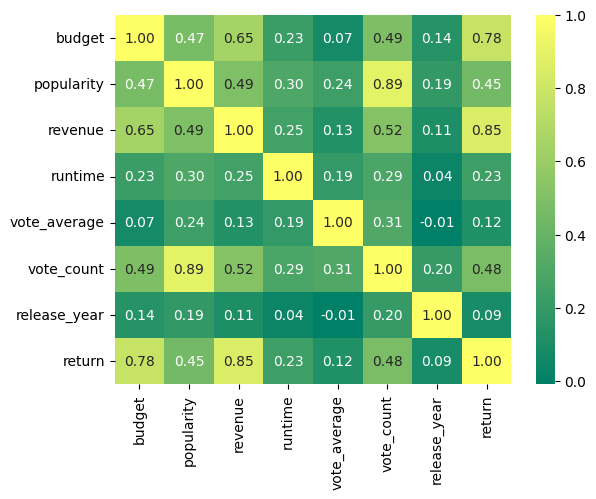

In [22]:
sns.heatmap(df_numeric.corr(method='spearman'),annot=True,fmt='.2f',cmap='summer')
plt.show()

Aclarar que correlacion no implica causalidad y considerar tambien que algunas variables no numericas podrian afectar tambien a la aplicacion de un modelo.

Para una futura aplicacion de un modelo que intente predecir los valores del presupuesto de la pelicula, en caso de desear saber si vale la pena o no hacer la pelicula, podrian considerarse usar columnas como revenue y popularity.

#### 2.1: Boxplots y outliers

In [23]:
from Funciones import grafico_de_caja
box = grafico_de_caja(df_numeric,column=df_numeric.columns)

NameError: name 'plt' is not defined

Algunas columnas presentan valores atipicos en los datos por lo que deberian analizarse particularmente para observar si son valores correctos o no lo son.

Valores por ejemplo de "runtime" que son outliers, podrian llegar a ser documentales de larga duracion por lo que su valor seria correcto.

#### 2.2 Histogramas y distribucion

In [ ]:
def graficar_histogramas(df, columnas):
  # Funcion para graficar todos los histogramas de cada una de las variables con los valores de asimetria y curtosis
  fig, axes = plt.subplots(nrows=len(columnas), ncols=1, figsize=(10, 4*len(columnas)))
  for i, columna in enumerate(columnas):
    # Graficar histograma
    sns.histplot(data=df, x=columna, ax=axes[i],bins=50)
    plt.xlim(auto=True)
    plt.ylim(auto=True)
  plt.tight_layout()
  return fig

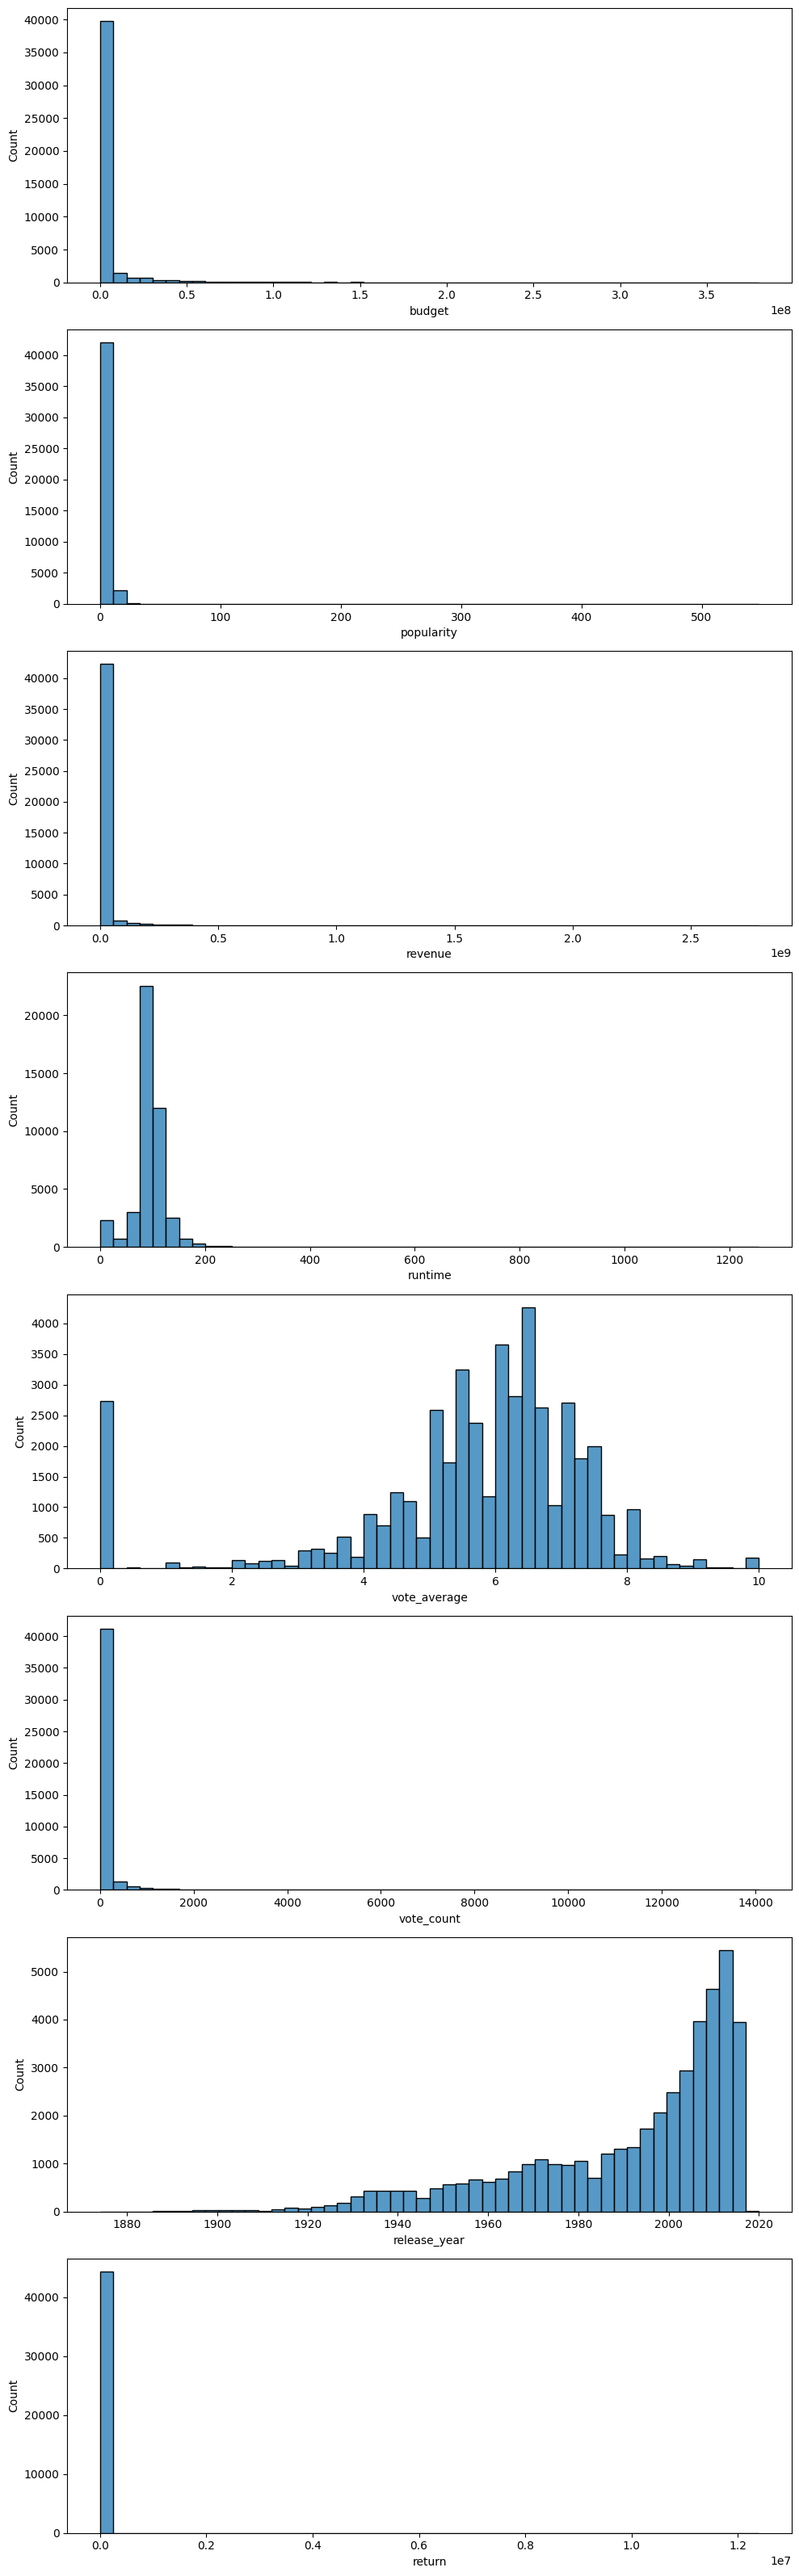

In [ ]:
hist = graficar_histogramas(df_numeric,df_numeric.columns)

#### 2.4 Analisis categorico

En esta seccion se analizaran las variables categoricas tanto del dataframe de peliculas como de credits



#### 2.4.1: departamentos de crew

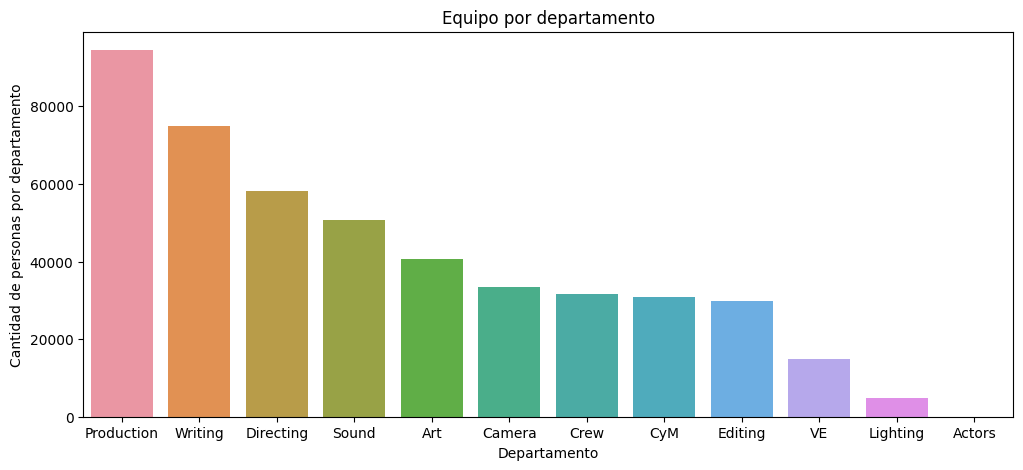

In [ ]:
#preparamos los nombres de las columnas para que puedan ser graficadas
filas_a_renombrar = df_crew["department"].str.contains("Costume & Make-Up")
filas_a_renombrar_ve = df_crew["department"].str.contains("Visual Effects")
diccionario_remplazo = {"Costume & Make-Up": "CyM"}
diccionario_remplazo_ve = {"Visual Effects": "VE"}
df_crew["department"].replace(diccionario_remplazo, inplace=True, regex=True)
df_crew["department"].replace(diccionario_remplazo_ve, inplace=True, regex=True)
top_categories = df_crew['department'].value_counts().nlargest(12).index
plt.figure(figsize=(12,5))
sns.countplot(data=df_crew,x='department',order=top_categories)
plt.title('Equipo por departamento')
plt.xlabel('Departamento')
plt.ylabel('Cantidad de personas por departamento')
plt.show()

Podemos observar que las categorias mas frecuentes son directing, writing, production y sound

#### 2.4.2 Jobs de crew (top10)
Debido a la cantidad tan variada que existe dentro de "job" del equipo, se analizara solamente los 10 trabajos que tengan mayor cantidad de personas.

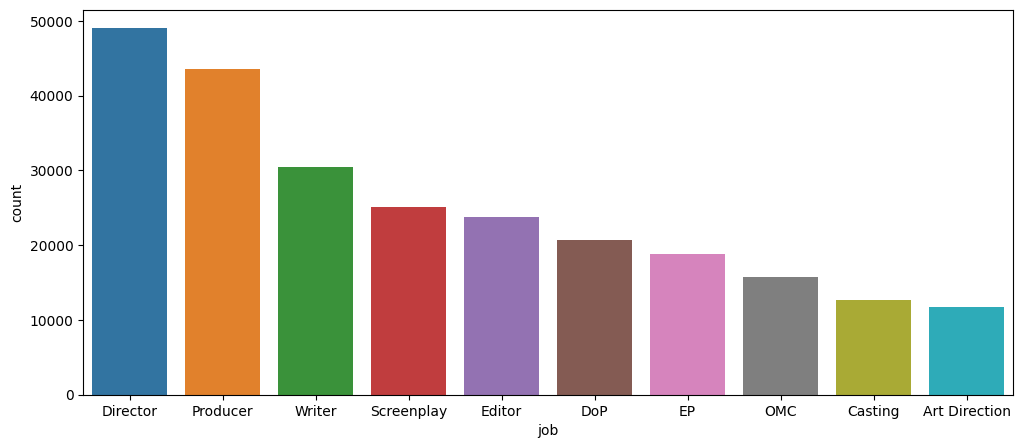

In [ ]:
filas_a_renombrar = df_crew["job"].str.contains("Director of Photography")
filas_a_renombrar_2 = df_crew["job"].str.contains("Executive Producer")
filas_a_renombrar_3 = df_crew["job"].str.contains("Original Music Composer")
diccionario_remplazo = {"Director of Photography": "DoP"}
diccionario_remplazo_2 = {"Executive Producer": "EP"}
diccionario_remplazo_3 = {"Original Music Composer": "OMC"}
df_crew["job"].replace(diccionario_remplazo, inplace=True, regex=True)
df_crew["job"].replace(diccionario_remplazo_2, inplace=True, regex=True)
df_crew["job"].replace(diccionario_remplazo_3, inplace=True, regex=True)
top_categories = df_crew['job'].value_counts().nlargest(10).index
plt.figure(figsize=(12,5))
sns.countplot(data=df_crew,x='job',order=top_categories)
plt.show()

#### 2.4.3 top 7 Actores (frecuencia) de cast

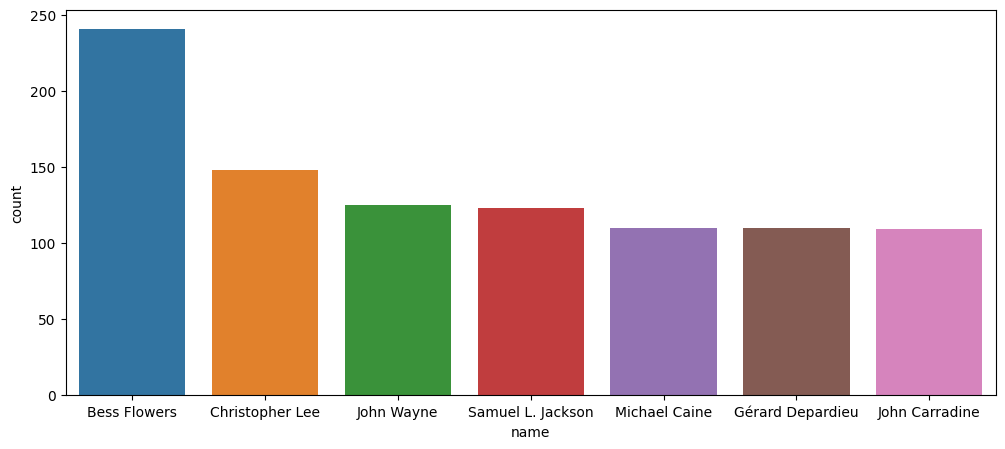

In [ ]:
top_categories = df_cast['name'].value_counts().nlargest(7).index
plt.figure(figsize=(12,5))
sns.countplot(data=df_cast,x='name',order=top_categories)
plt.show()

#### 2.4.4 Distribucion de generos del casting

<AxesSubplot: ylabel='count'>

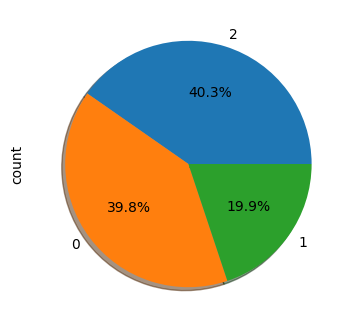

In [ ]:
plt.figure(figsize=(6,4))
df_cast['gender'].value_counts().plot.pie(autopct='%0.1f%%',shadow=True)

transformar los datos de genres de str json a una lista de python

In [ ]:
df_movies['genres'] = df_movies['genres'].apply(json.loads)
def juntar_listas(lista):
  if isinstance(lista, (list)):
    return ','.join([str(elemento[1]) for elemento in lista])
df_movies['generos'] = df_movies['genres'].apply(juntar_listas)
df_movies['generos'] = df_movies['generos'].apply(lambda x: x.split(','))

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
generos_dummies = mlb.fit_transform(df_movies["generos"])
generos_df = pd.DataFrame(generos_dummies, columns=mlb.classes_)
df_movies = pd.concat([df_movies, generos_df], axis=1)

#### 2.5 Distribucion del genero de las peliculas

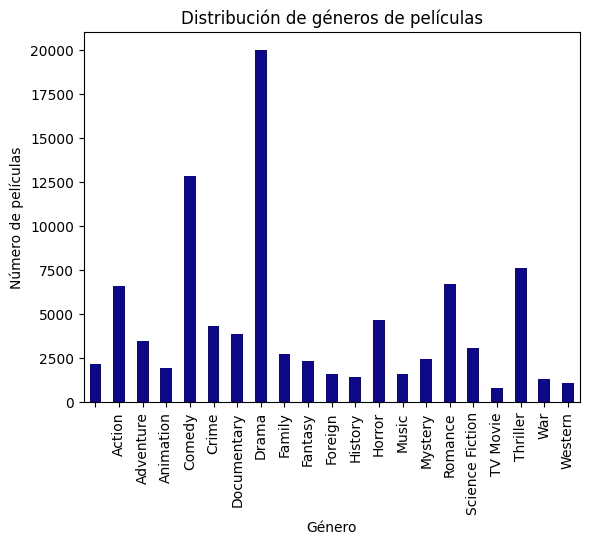

In [ ]:
# Graficar la distribución de géneros
generos_df.sum().plot(kind="bar",colormap='plasma')
plt.xlabel("Género")
plt.ylabel("Número de películas")
plt.title("Distribución de géneros de películas")
plt.show()

#### 3.0 Analisis de la popularidad de las peliculas en base al tiempo

In [ ]:
from datetime import datetime
df_movies.dropna(subset=['release_date'],inplace=True)
#la columna 'weekend' que indica si el dia es un dia de la semana (weekday = 1) o si es fin de semana(weekday= 0 =weekend)
#la columna 'weekday' que indica el numero de la semana. 0 = Lunes, 1 = Martes, 6 = Domingo
df_movies['weekend'] = df_movies['release_date'].apply(lambda x: x.weekday() < 5).astype(int)
df_movies['weekday'] = df_movies['release_date'].apply(lambda x: x.weekday())
# Creamos las columnas de trimestre, mes y decada
df_movies['quarter'] = df_movies['release_date'].apply(lambda x: x.quarter)
df_movies['month'] = df_movies['release_date'].apply(lambda x: x.month)
df_movies['decada'] = (df_movies['release_year'] // 10) * 10

In [ ]:
def variable_tiempo(df,variable,columnas_tiempo):
    # funcion creada para ver la acumulacion de valores en diferentes marcos temporales de una variable.
    #columnas_tiempo = ['year','quarter','month','weekday','hour','weekend']
    plt.figure(figsize=(18, 14))
    y = 3
    x = 2
    z = 1
    for col in columnas_tiempo:
        plt.subplot(x,y,z,facecolor = 'skyblue')
        z += 1
        df.groupby(col)[variable].sum().plot(kind='bar',color='green')
        plt.title(f'{variable} vs {col}')
        plt.xlabel(col)
        plt.ylabel("kW")



#### 3.1 Marcos temporales de popularidad

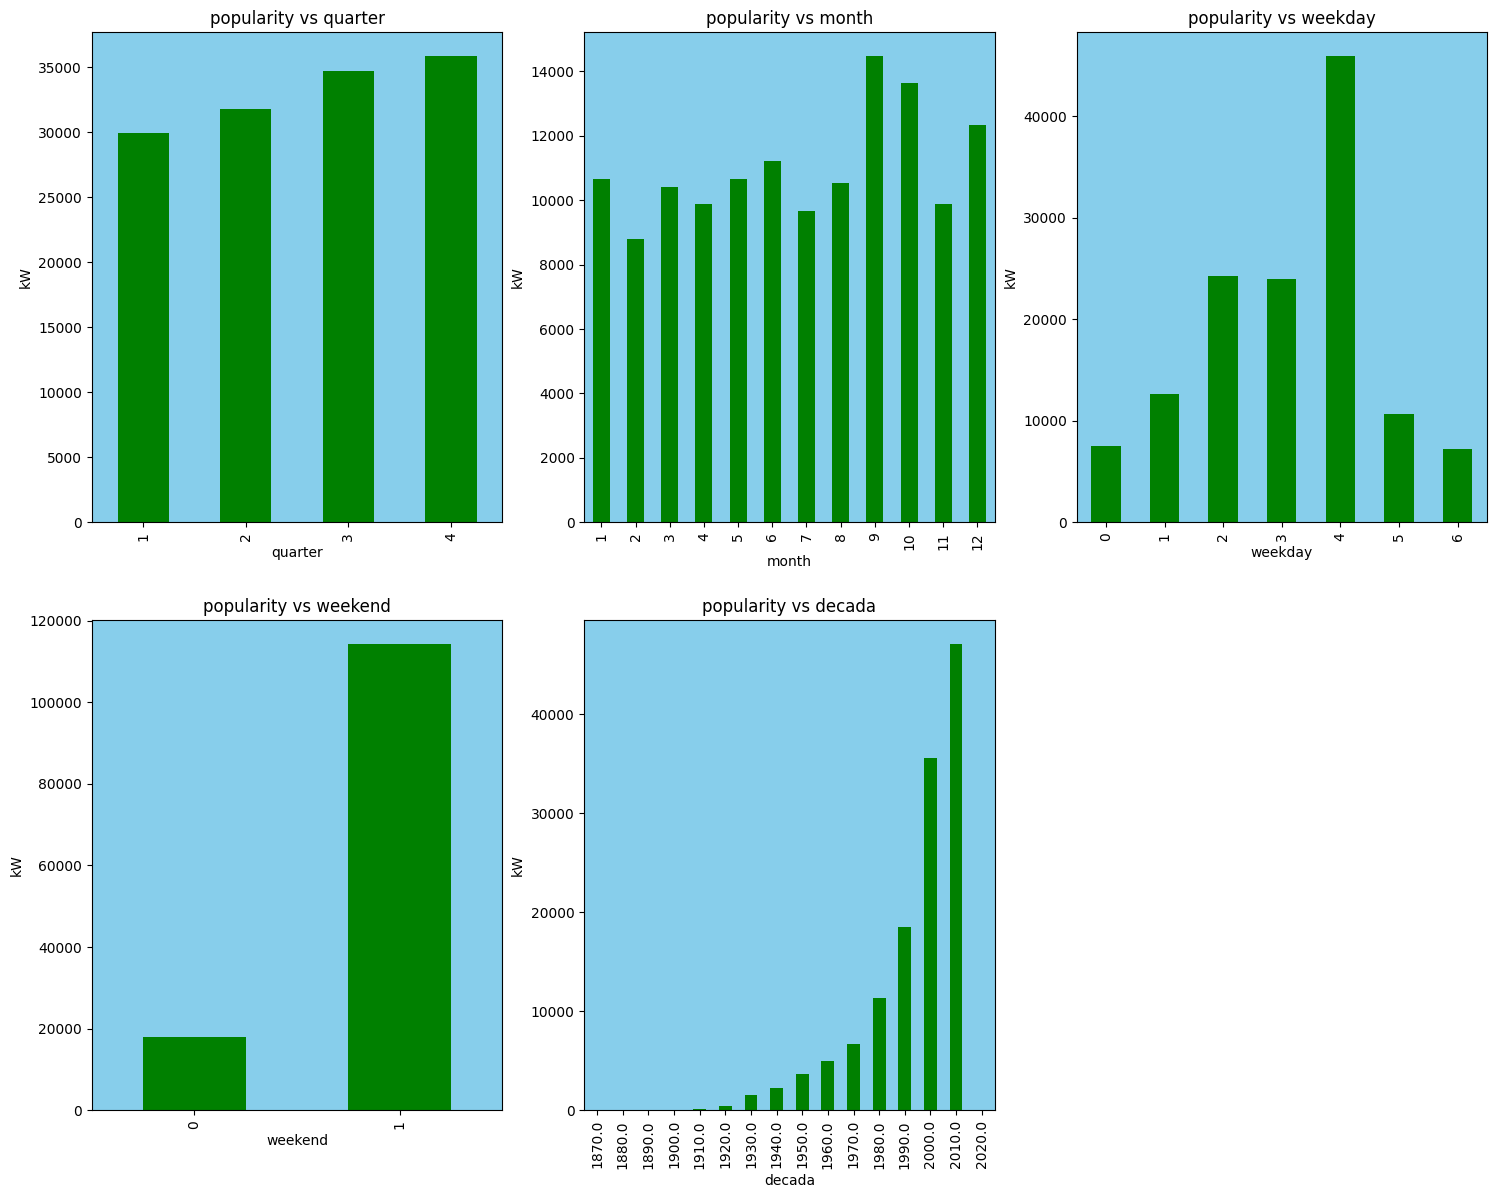

In [ ]:
var = 'popularity'
cols = ['quarter','month','weekday','weekend','decada']
marco_temporal = variable_tiempo(df_movies,var,columnas_tiempo=cols)

Se puede observar que el cuarto trimestre o cuarto cuarto valga la redundancia, corresponde al cuarto mayor popularidad, si nos situamos en que se estrenan en USA, el cuarto trimestre en los Estados Unidos comienza el 1 de octubre y termina el 31 de diciembre siendo estas las fechas de mayor popularidad.
El mes septiembre corresponde al mes con mayor popularidad.

Respecto a la decada, podemos observar que existe una tendencia al alza a medida que avanza el tiempo, y tambien se podria intentar conseguir mas datos acerca de la decada siguiente para evaluar si sigue existiendo esta tendencia.

#### 3.2 Grafico anual de popularidad

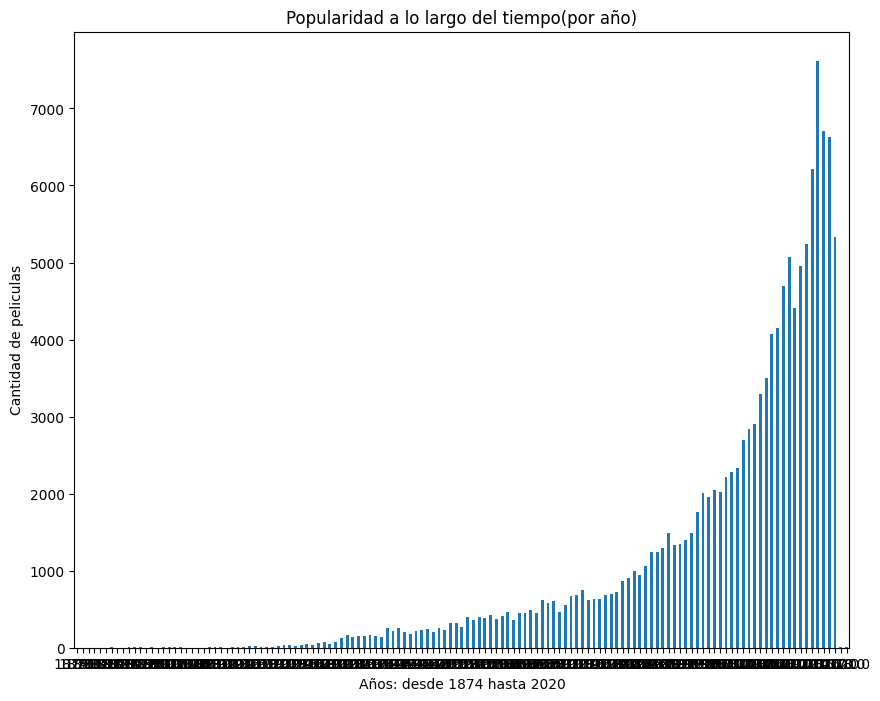

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
plt.gca().set_xticks([])
df_movies.groupby('release_year')['popularity'].sum().plot(kind='bar')
plt.title('Popularidad a lo largo del tiempo(por año)')
plt.xlabel("Años: desde 1874 hasta 2020")
plt.ylabel("Cantidad de peliculas")
plt.show()

### 4.0 Nube de palabras de las peliculas

In [ ]:
wc = WordCloud(background_color='white', width=800, height=600).generate(' '.join(x for x in df_movies['overview_tokenizado']))

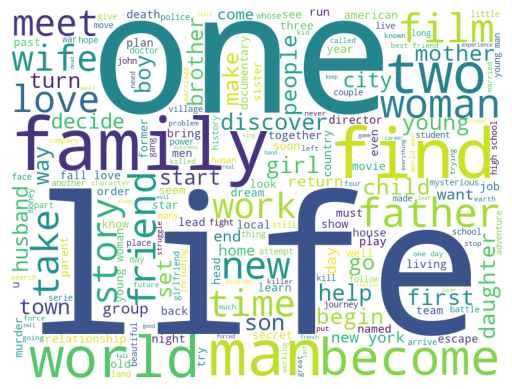

In [ ]:
plt.imshow(wc)
plt.axis('off')
plt.show()

### 5.0 Correlacion de Popularidad

In [42]:
correlation_matrix = df_numeric.corr()
popularity = 'popularity'
correlaciones = correlation_matrix[popularity] # Extraer las correlaciones de esa variable con todas las demás
# Muestra las correlaciones
print(correlaciones)

budget          0.448638
popularity      1.000000
revenue         0.505775
runtime         0.125005
vote_average    0.152379
vote_count      0.559351
release_year    0.133958
return          0.003141
Name: popularity, dtype: float64


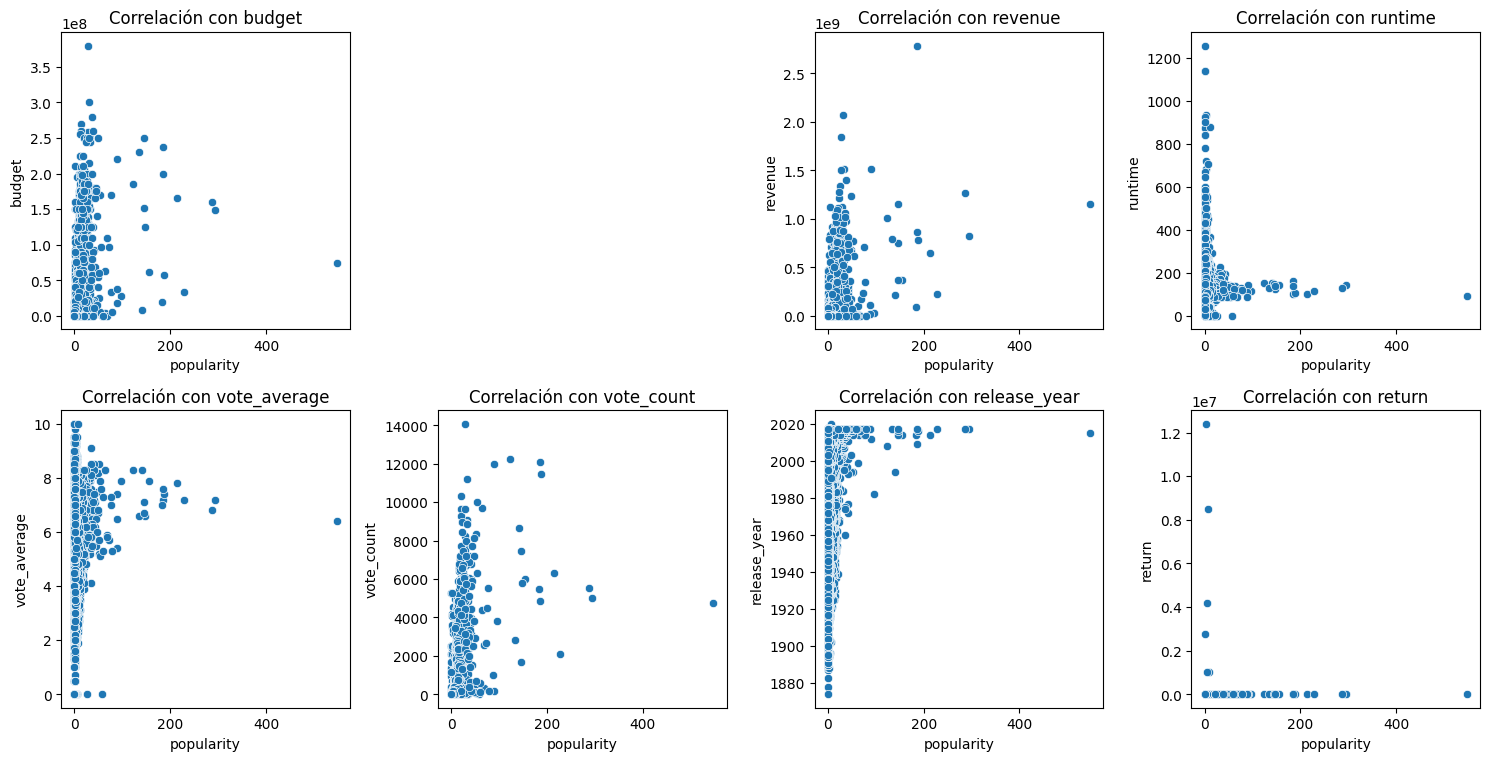

In [52]:
plt.figure(figsize=(15, 15))
# Iterar sobre todas las columnas del DataFrame
for i, col in enumerate(df_numeric.columns):
    if col != popularity:  # Esta linea evita que se grafique la variable de interes consigo misma
        plt.subplot(4, 4, i+1)  # Ajustar el tamaño de la cuadrícula según la cantidad de variables
        sns.scatterplot(data=df_numeric, x=popularity, y=col)
        plt.title(f'Correlación con {col}')

plt.tight_layout()
plt.show()